# Loan Prediction

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

In [3]:
train_data.shape

(614, 13)

In [4]:
test_data.shape

(367, 12)

#### Creating a backup file

In [5]:
train_data_og = train_data.copy()
test_data_og = test_data.copy()

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

In [7]:
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [8]:
test_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [9]:
train_data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [10]:
train_data.shape, test_data.shape

((614, 13), (367, 12))

In [11]:
train_data.Loan_Status.value_counts(normalize=True) # normalize help in normalizing the values

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

There isnt a good bal between our target which needs to be managed using ROS method or stratify

#### Visualising Categorical variables

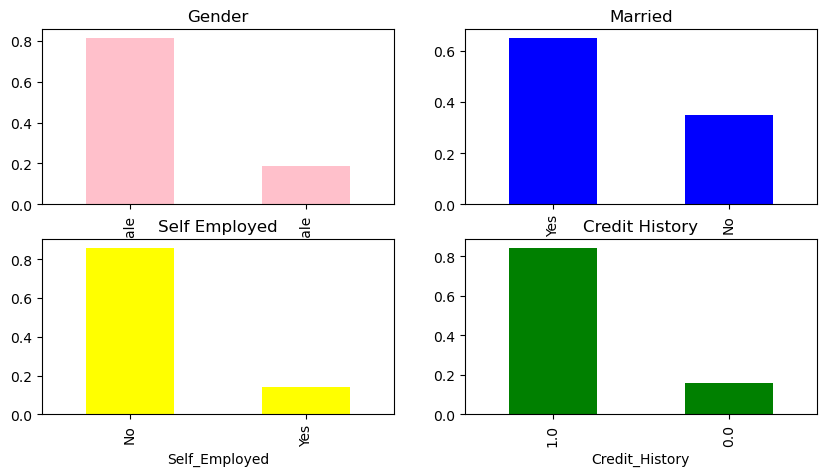

In [12]:
plt.figure(1)
plt.subplot(2,2,1)
train_data.Gender.value_counts(normalize=True).plot.bar(figsize=(10, 5), title="Gender", color="pink")
plt.subplot(2,2,2)
train_data.Married.value_counts(normalize=True).plot.bar(figsize=(10, 5), title="Married", color="blue")
plt.subplot(2,2,3)
train_data.Self_Employed.value_counts(normalize=True).plot.bar(figsize=(10, 5), title="Self Employed", color="yellow")
plt.subplot(2,2,4)
train_data.Credit_History.value_counts(normalize=True).plot.bar(figsize=(10, 5), title="Credit History", color="green")

plt.show()

Most loan Applicants are male, married and not self_employed with a 1.0 credit history

#### Visualising Ordinal variables

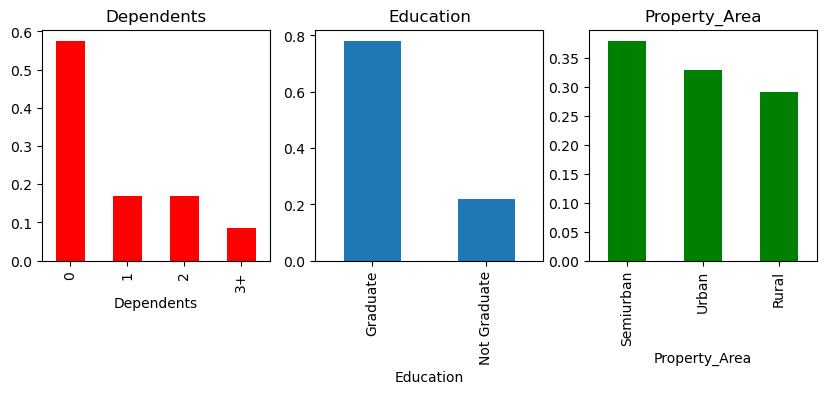

In [13]:
plt.figure(1)
plt.subplot(1,3,1)
train_data['Dependents'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Dependents',color='red')
plt.subplot(1,3,2)
train_data['Education'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Education')
plt.subplot(1,3,3)
train_data['Property_Area'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Property_Area',color='green')
plt.show()

Most applicants dont have dependents are graduates and belong from semiurban area

In [14]:
train_data['Dependents'] = train_data['Dependents'].replace('3+', '3')

#### Visualising Numeric Variables and checking for outliers

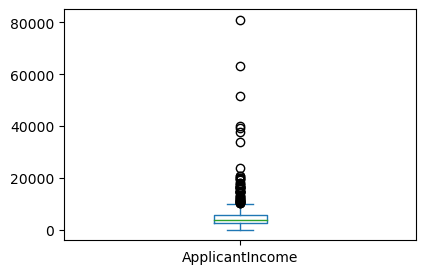

In [15]:
plt.figure(1)
plt.subplot(1,2,1)
# sns.distplot(train_data.ApplicantIncome)
# plt.subplot(1,2,2)
train_data.ApplicantIncome.plot.box(figsize=(10, 3))
plt.show()

We can observe that there is high left skewness in the applicant income which means there are outliers which needs to be treated before we build our model

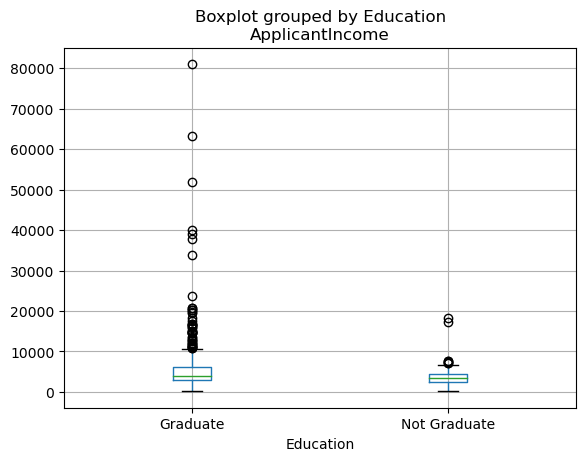

In [16]:
#Visualizing the application income considering whether applicant is graduate or not

train_data.boxplot(column="ApplicantIncome", by="Education")
plt.show()

We can observe that most anomalies are in case of Graduates compared to non graduates

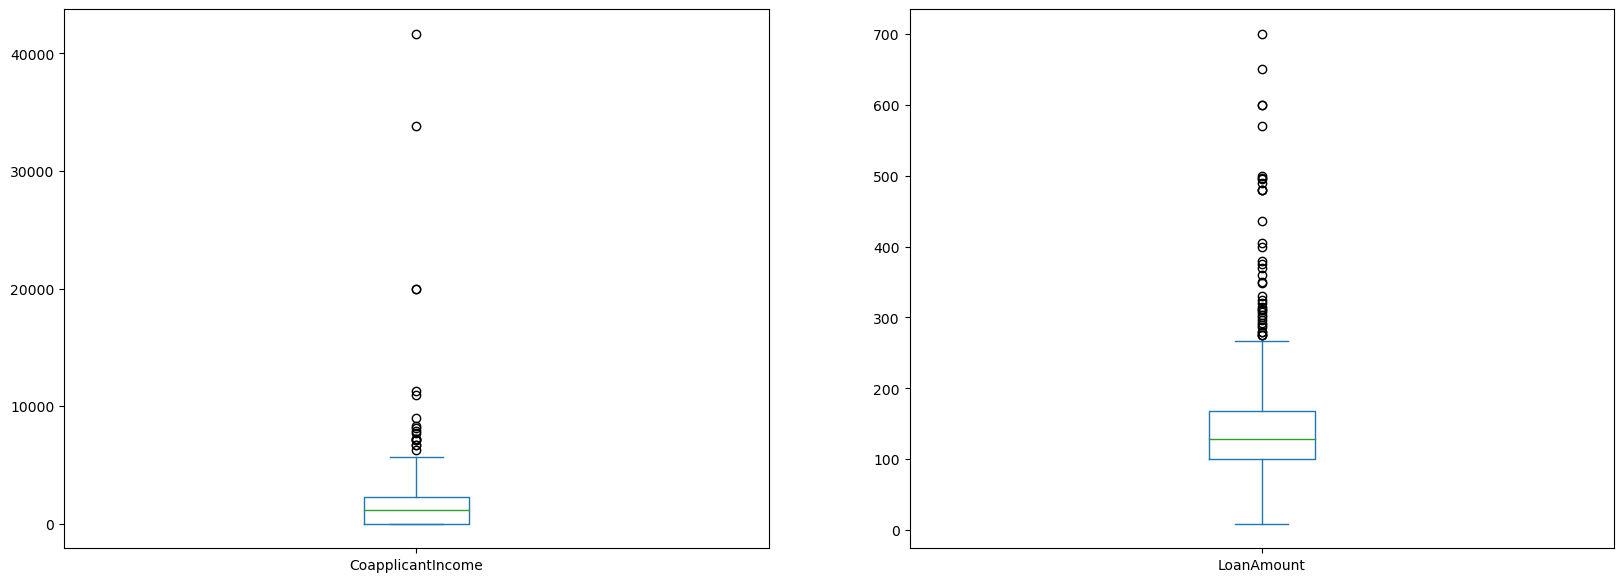

In [17]:
plt.figure(1)
plt.subplot(1,2,1)
train_data['CoapplicantIncome'].plot.box(figsize=(20,7))
plt.subplot(1,2,2)
train_data['LoanAmount'].plot.box()
plt.show()

#### Bivariate Analysis

<Figure size 640x480 with 0 Axes>

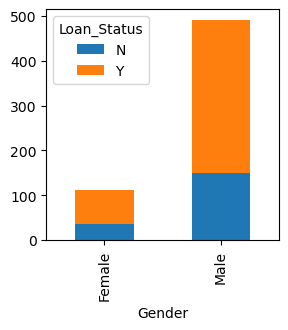

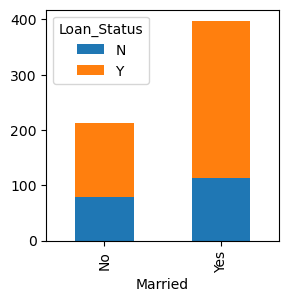

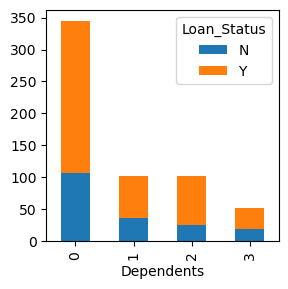

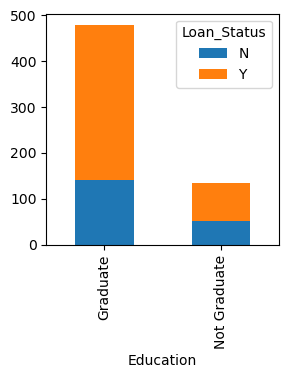

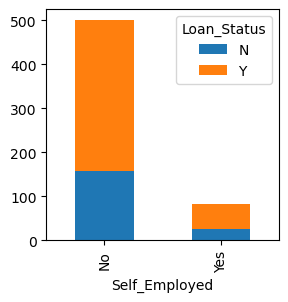

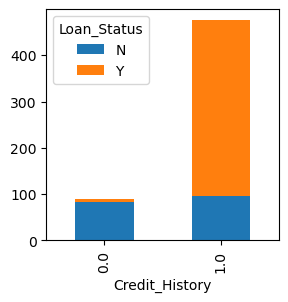

In [18]:
plt.figure(4)

gender = pd.crosstab(train_data.Gender, train_data.Loan_Status)
gender.plot.bar(stacked=True, figsize=(3,3))

married=pd.crosstab(train_data['Married'],train_data['Loan_Status'])
married.plot(kind='bar',stacked=True,figsize=(3,3))

dependents=pd.crosstab(train_data['Dependents'],train_data['Loan_Status'])
dependents.plot(kind='bar',stacked=True,figsize=(3,3))

education=pd.crosstab(train_data['Education'],train_data['Loan_Status'])
education.plot(kind='bar',stacked=True,figsize=(3,3))

selfemployed=pd.crosstab(train_data['Self_Employed'],train_data['Loan_Status'])
selfemployed.plot(kind='bar',stacked=True,figsize=(3,3))

credithistory=pd.crosstab(train_data['Credit_History'],train_data['Loan_Status'])
credithistory.plot(kind='bar',stacked=True,figsize=(3,3))

plt.show()

From the above visualisation its clear that mostly graduates, self-employed and applicants with 0 dependents have high chances of loan approval
Applicants whose credit history is 0 have very low chances of getting loan

In [19]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


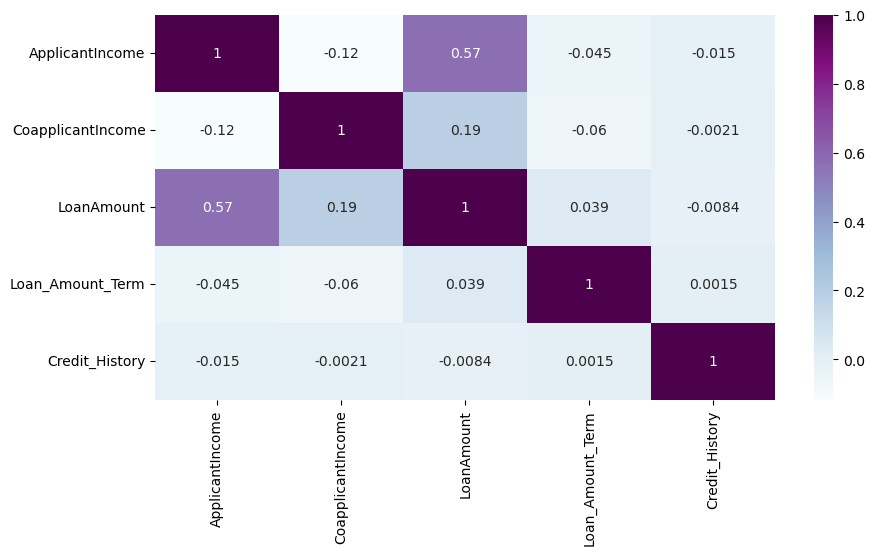

In [20]:
plt.figure(figsize=(10,5))

corr_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

sns.heatmap(train_data[corr_columns].corr(), cmap="BuPu", annot=True)
plt.show()

There's about 50% correlation between loan amount and applicant income

### Missing Value Inputation

In [21]:
train_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [23]:
#Creating variables that stores all numeric and object columns

numeric_columns = train_data.select_dtypes([int, float]).columns
categorical_column = train_data.select_dtypes([object]).columns

print("numeric_columns >> ", numeric_columns)
print("categorical_column >> ", categorical_column)

numeric_columns >>  Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')
categorical_column >>  Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [24]:
#Inputing the missing numeric data with mean value


for i in numeric_columns:
    print('mean >> ', round(train_data[i].mean(), 2))
    train_data[i].fillna(round(train_data[i].mean(), 2),inplace=True)

mean >>  5403.46
mean >>  1621.25
mean >>  146.41
mean >>  342.0
mean >>  0.84


In [25]:
#Imputing object data with mode
for i in categorical_column:
    print(i,':', train_data[i].mode()[0])
    train_data[i].fillna(train_data[i].mode()[0],inplace=True)

Loan_ID : LP001002
Gender : Male
Married : Yes
Dependents : 0
Education : Graduate
Self_Employed : No
Property_Area : Semiurban
Loan_Status : Y


In [26]:
train_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

No more missing values

### Understanding the uniqueness of our data

In [27]:
# Checking features with low uniqueness

train_data.nunique()

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           204
Loan_Amount_Term      11
Credit_History         3
Property_Area          3
Loan_Status            2
dtype: int64

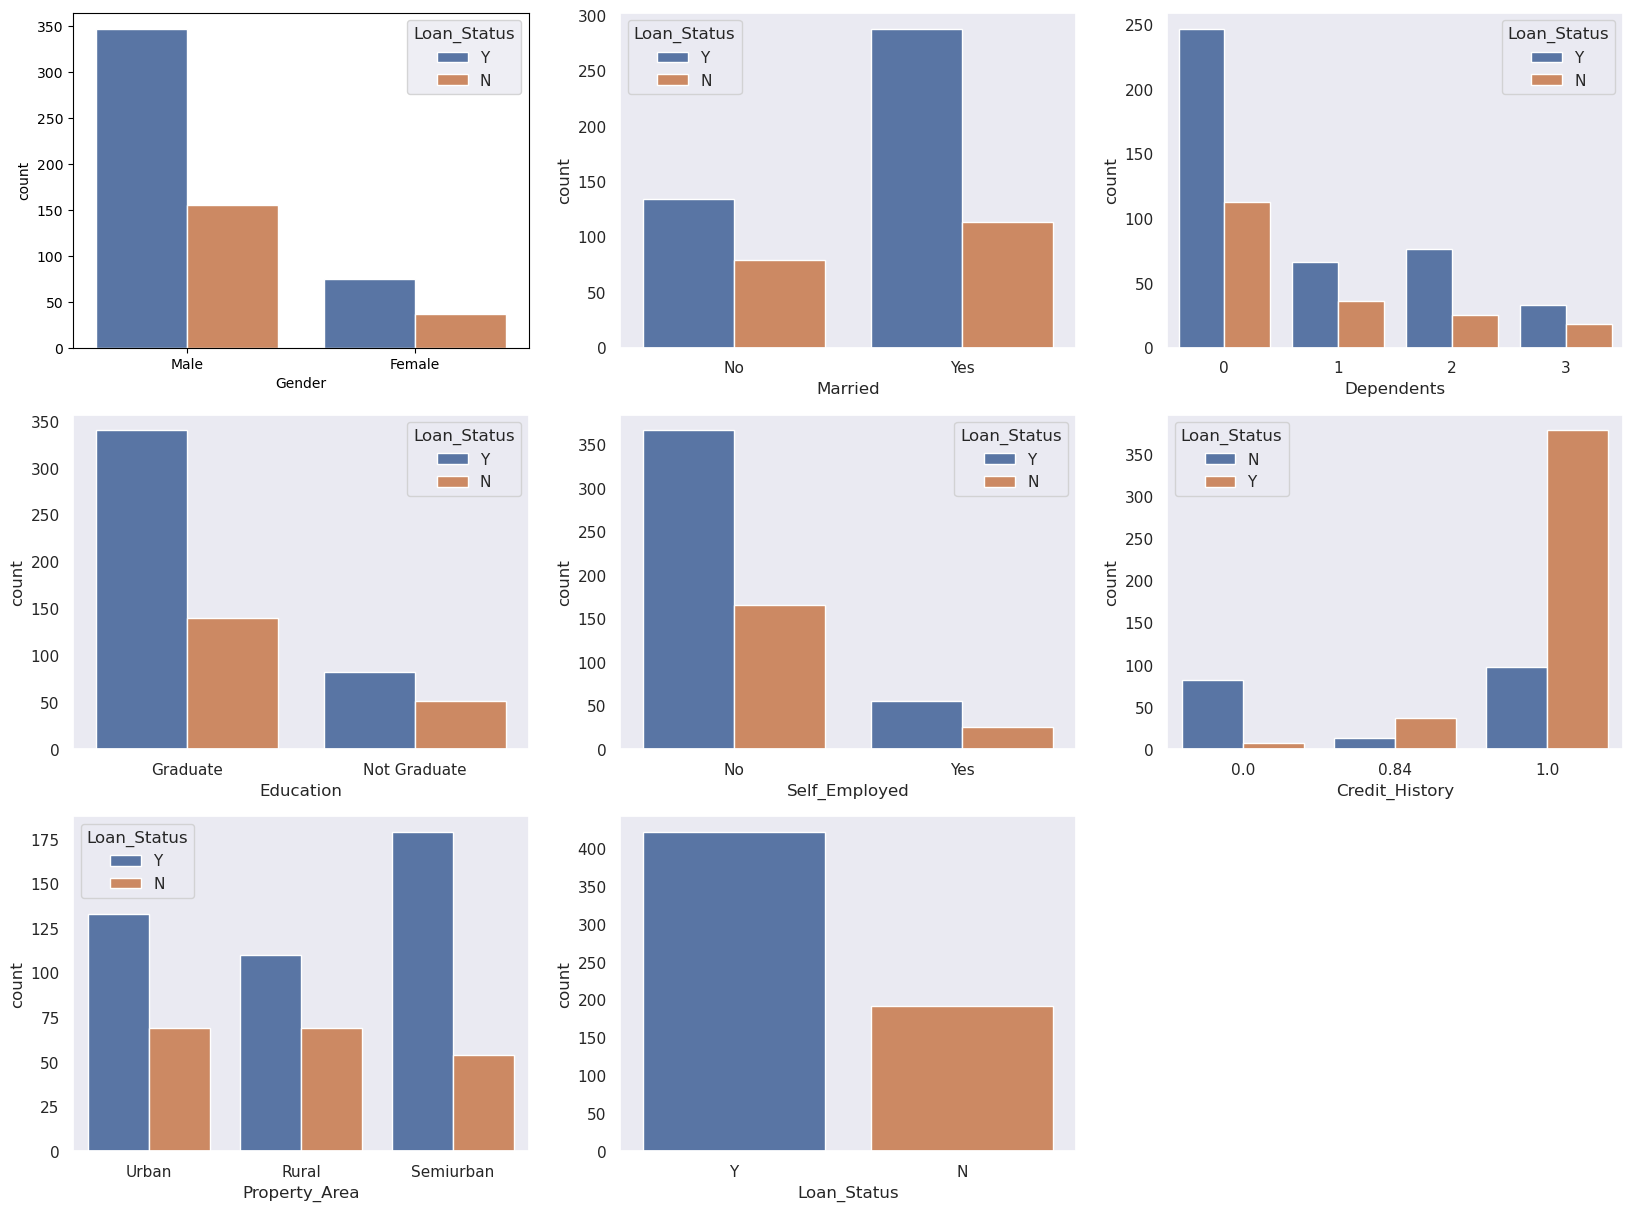

In [28]:
# Visualizing features with low uique values for better understanding

low_unique_columns = ['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area','Loan_Status']

plt.figure(figsize=(20,20))
for i, col in enumerate(low_unique_columns):
    plt.subplot(4,3,i+1)
    sns.set(style='dark')
    sns.countplot(x = train_data[col], hue=train_data['Loan_Status'])

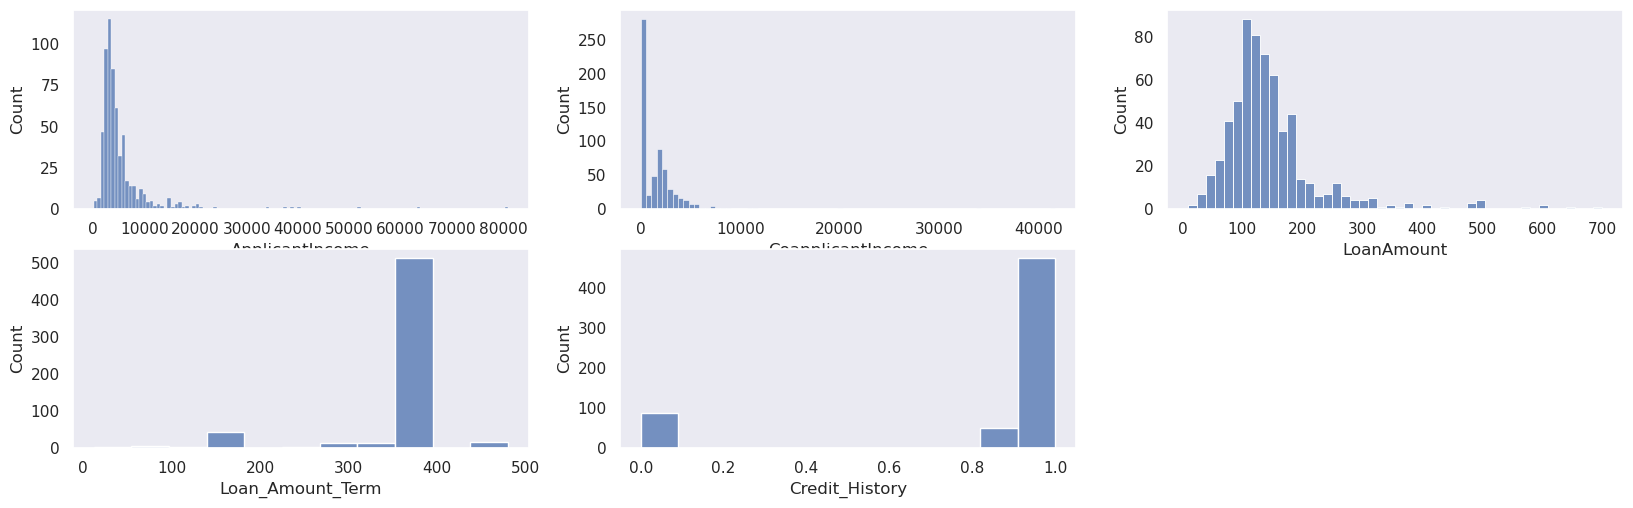

In [29]:
plt.figure(figsize=(20,15))
for i,col in enumerate(numeric_columns):
    plt.subplot(5,3,i+1)
    sns.set_style('dark')
    sns.histplot(train_data[col])
plt.show()

Drop loan amount greater than 400

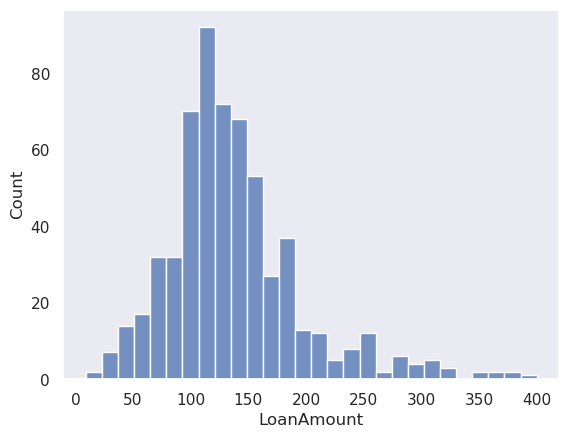

In [30]:
train_data.drop(train_data[train_data.LoanAmount > 400].index, inplace=True)
sns.histplot(train_data["LoanAmount"])
plt.show()

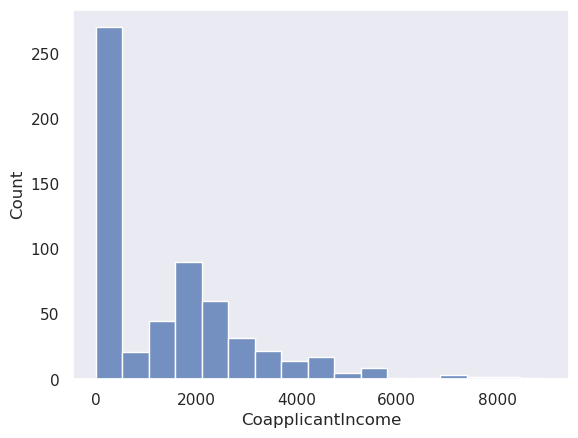

In [31]:
train_data.drop(train_data[train_data.CoapplicantIncome > 10000].index, inplace=True)
sns.histplot(train_data["CoapplicantIncome"])
plt.show()

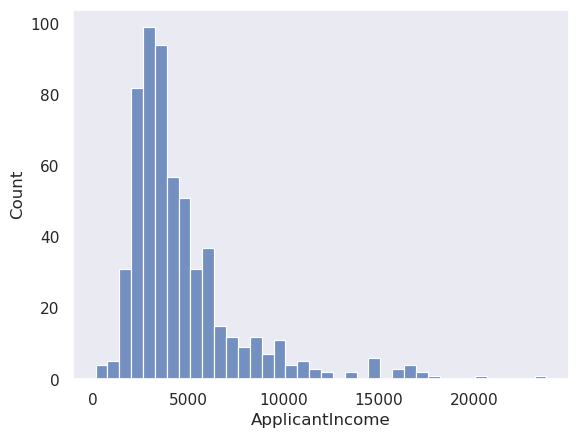

In [32]:
train_data.drop(train_data[train_data.ApplicantIncome > 25000].index, inplace=True)
sns.histplot(train_data["ApplicantIncome"])
plt.show()

### Treating object data types for model building


In [33]:
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            591 non-null    object 
 1   Gender             591 non-null    object 
 2   Married            591 non-null    object 
 3   Dependents         591 non-null    object 
 4   Education          591 non-null    object 
 5   Self_Employed      591 non-null    object 
 6   ApplicantIncome    591 non-null    int64  
 7   CoapplicantIncome  591 non-null    float64
 8   LoanAmount         591 non-null    float64
 9   Loan_Amount_Term   591 non-null    float64
 10  Credit_History     591 non-null    float64
 11  Property_Area      591 non-null    object 
 12  Loan_Status        591 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 64.6+ KB


In [35]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.41,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.00,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.00,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.00,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.00,360.0,1.0,Urban,Y


In [36]:
train_data['Dependents'] = train_data['Dependents'].astype(int)

In [37]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            591 non-null    object 
 1   Gender             591 non-null    object 
 2   Married            591 non-null    object 
 3   Dependents         591 non-null    int64  
 4   Education          591 non-null    object 
 5   Self_Employed      591 non-null    object 
 6   ApplicantIncome    591 non-null    int64  
 7   CoapplicantIncome  591 non-null    float64
 8   LoanAmount         591 non-null    float64
 9   Loan_Amount_Term   591 non-null    float64
 10  Credit_History     591 non-null    float64
 11  Property_Area      591 non-null    object 
 12  Loan_Status        591 non-null    object 
dtypes: float64(4), int64(2), object(7)
memory usage: 64.6+ KB


In [38]:
#Mapping the object columns to convert it into binary from and then change the data type to int
train_data['Married']=train_data['Married'].map({'Yes':1, 'No':0})
train_data['Education']=train_data['Education'].map({'Graduate':1, 'Not Graduate':0})
train_data['Self_Employed']=train_data['Self_Employed'].map({'Yes':1, 'No':0})
train_data['Loan_Status']=train_data['Loan_Status'].map({'Y':1, 'N':0})

In [39]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,0,0,1,0,5849,0.0,146.41,360.0,1.0,Urban,1
1,LP001003,Male,1,1,1,0,4583,1508.0,128.00,360.0,1.0,Rural,0
2,LP001005,Male,1,0,1,1,3000,0.0,66.00,360.0,1.0,Urban,1
3,LP001006,Male,1,0,0,0,2583,2358.0,120.00,360.0,1.0,Urban,1
4,LP001008,Male,0,0,1,0,6000,0.0,141.00,360.0,1.0,Urban,1


In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            591 non-null    object 
 1   Gender             591 non-null    object 
 2   Married            591 non-null    int64  
 3   Dependents         591 non-null    int64  
 4   Education          591 non-null    int64  
 5   Self_Employed      591 non-null    int64  
 6   ApplicantIncome    591 non-null    int64  
 7   CoapplicantIncome  591 non-null    float64
 8   LoanAmount         591 non-null    float64
 9   Loan_Amount_Term   591 non-null    float64
 10  Credit_History     591 non-null    float64
 11  Property_Area      591 non-null    object 
 12  Loan_Status        591 non-null    int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 64.6+ KB


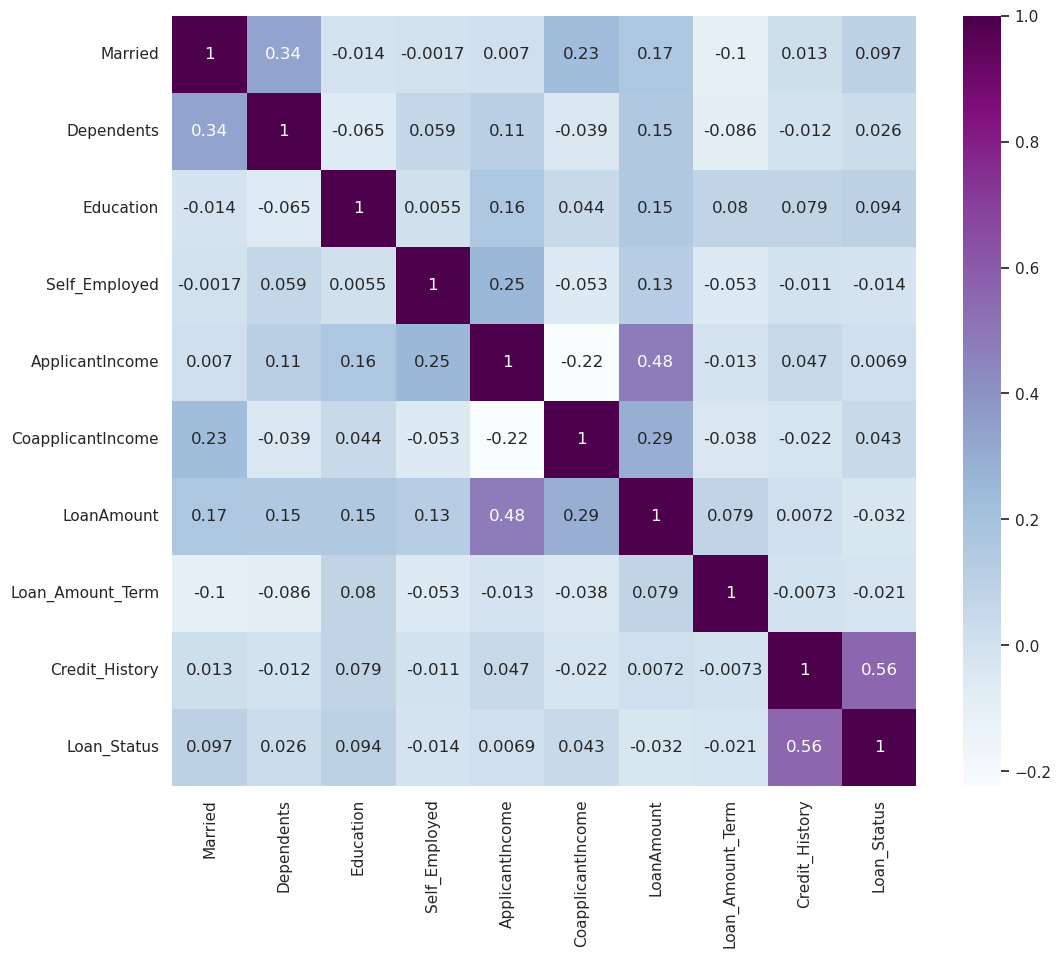

In [98]:
column_corr = train_data.select_dtypes([int, float]).columns

corr2 = train_data[column_corr].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr2, cmap="BuPu", annot=True)
plt.show()

In [41]:
#Droping redundant columns
train_data.drop('Loan_ID', axis=1, inplace=True)
train_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,0,0,1,0,5849,0.0,146.41,360.0,1.0,Urban,1
1,Male,1,1,1,0,4583,1508.0,128.00,360.0,1.0,Rural,0
2,Male,1,0,1,1,3000,0.0,66.00,360.0,1.0,Urban,1
3,Male,1,0,0,0,2583,2358.0,120.00,360.0,1.0,Urban,1
4,Male,0,0,1,0,6000,0.0,141.00,360.0,1.0,Urban,1


In [42]:
#copy to new variable
train_data_copy = train_data.copy()


In [43]:
#Using get dummies for the remaining object columns for which mapping or encoder cant be used 

train_data_copy = pd.get_dummies(train_data_copy)
train_data_copy.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0,1,0,5849,0.0,146.41,360.0,1.0,1,False,True,False,False,True
1,1,1,1,0,4583,1508.0,128.00,360.0,1.0,0,False,True,True,False,False
2,1,0,1,1,3000,0.0,66.00,360.0,1.0,1,False,True,False,False,True
3,1,0,0,0,2583,2358.0,120.00,360.0,1.0,1,False,True,False,False,True
4,0,0,1,0,6000,0.0,141.00,360.0,1.0,1,False,True,False,False,True


In [44]:
train_data_copy.dtypes

Married                      int64
Dependents                   int64
Education                    int64
Self_Employed                int64
ApplicantIncome              int64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Loan_Status                  int64
Gender_Female                 bool
Gender_Male                   bool
Property_Area_Rural           bool
Property_Area_Semiurban       bool
Property_Area_Urban           bool
dtype: object

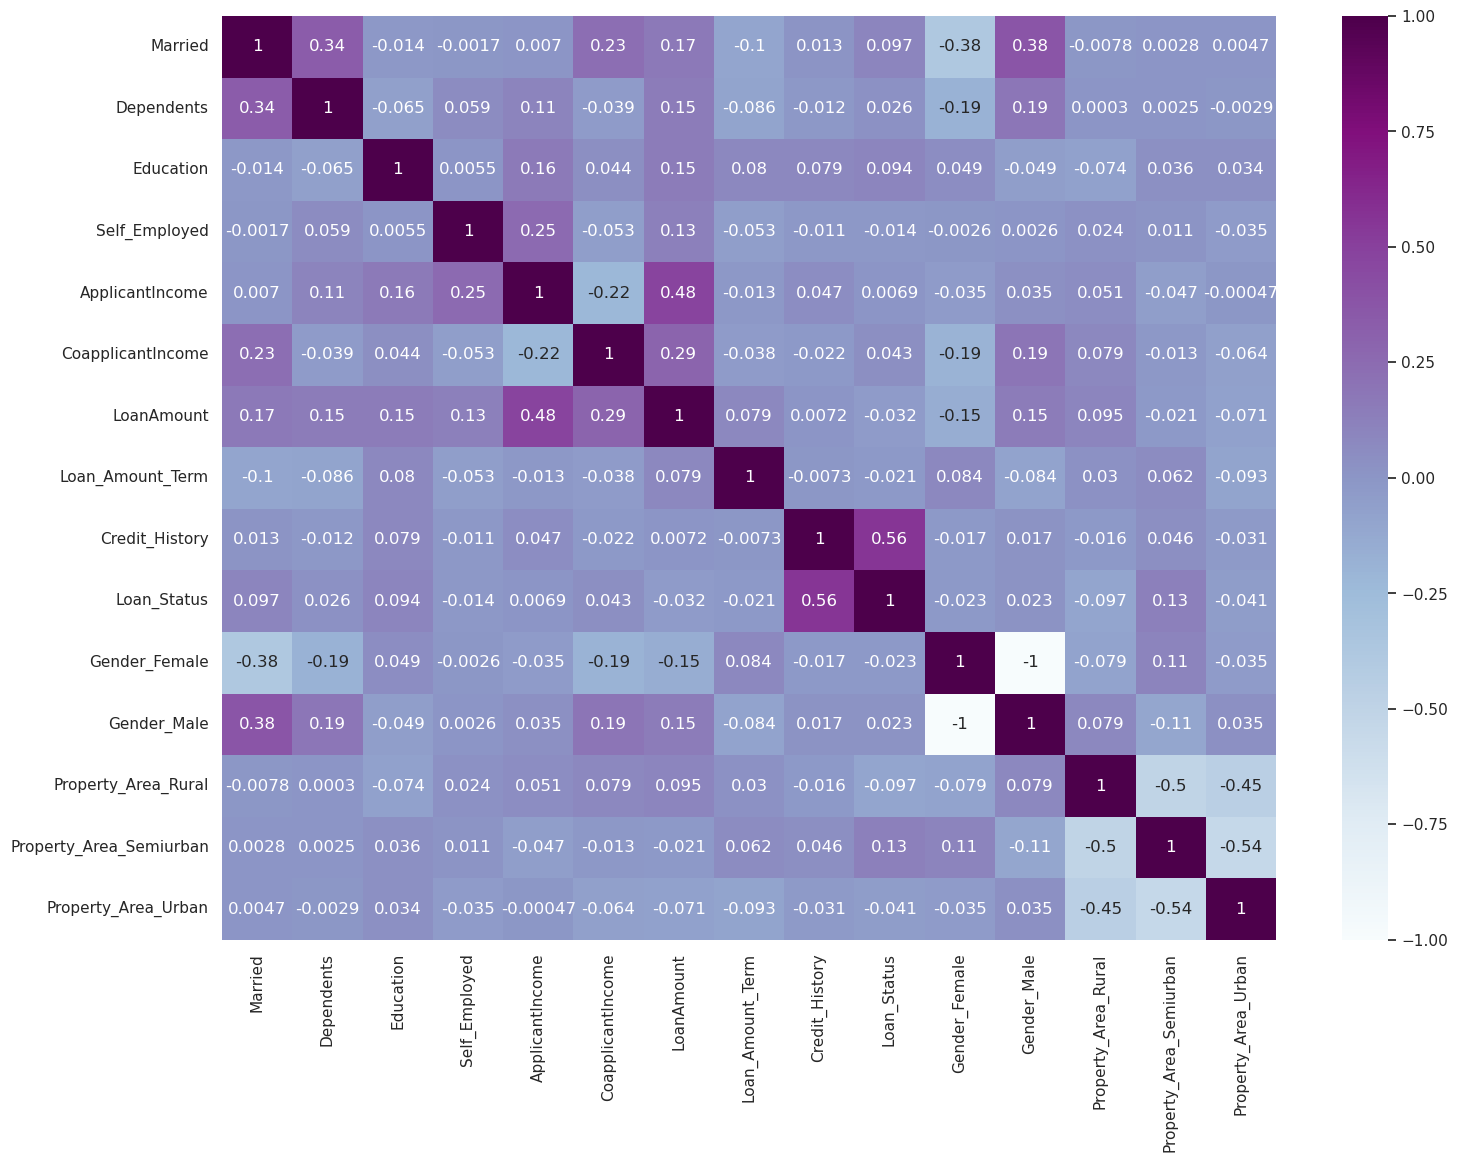

In [45]:
plt.figure(figsize=(17, 12))

sns.heatmap(train_data_copy.corr(), cmap="BuPu", annot=True)
plt.show()

In [46]:
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 0 to 613
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Married                  591 non-null    int64  
 1   Dependents               591 non-null    int64  
 2   Education                591 non-null    int64  
 3   Self_Employed            591 non-null    int64  
 4   ApplicantIncome          591 non-null    int64  
 5   CoapplicantIncome        591 non-null    float64
 6   LoanAmount               591 non-null    float64
 7   Loan_Amount_Term         591 non-null    float64
 8   Credit_History           591 non-null    float64
 9   Loan_Status              591 non-null    int64  
 10  Gender_Female            591 non-null    bool   
 11  Gender_Male              591 non-null    bool   
 12  Property_Area_Rural      591 non-null    bool   
 13  Property_Area_Semiurban  591 non-null    bool   
 14  Property_Area_Urban      591 no

### Model Building

In [51]:
### Splitting the dataset into feature and target.

X = train_data_copy.drop('Loan_Status', axis=1)
y = train_data_copy["Loan_Status"]

X.shape, y.shape

((591, 14), (591,))

In [52]:
# Further splitting data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((443, 14), (148, 14), (443,), (148,))

### Using Logistic Regression

In [53]:
lr_model = LogisticRegression(random_state=42)

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8378378378378378
[[27 19]
 [ 5 97]]
              precision    recall  f1-score   support

           0       0.84      0.59      0.69        46
           1       0.84      0.95      0.89       102

    accuracy                           0.84       148
   macro avg       0.84      0.77      0.79       148
weighted avg       0.84      0.84      0.83       148

